```
Transfer learning на Keras с CNTK и LightGBM для классификации изображений
```

Код в этом notebook отвечает за бинарную классификацию изображений, которые были подготовены ранее.
Т.е. мы будем относить каждой изображенеи к одной из двух категорий.
В нашем случае это - легковой автомобиль и все остальное.
Одним из основных сценариев обучения передаче данных является использование сети, предварительно обученной на большом наборе данных (изображений).
В примере используется подход Convolutional Neural Network (CNN) под названием ResNet50, предварительно обученный на наборе данных ImageNet, который содержит 1,2 миллиона изображений, которые разнесены по 1000 категорий.
Сначала вы удалите последний сетевой слой, чтобы создать визуальные элементы изображений. Затем вы будете использовать эти функции для обучения  boosted decision tree для классификации изображений как pass (автомобиль) или неудачных (в нашем наборе автобусы).
Вы будете использовать в Keras с  CNTK-toolkit в качестве CNN и LightGBM для бинарной классификации.

In [91]:
#!L
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import io
from os import path
from glob import iglob
from tqdm import tqdm
import itertools
import numpy as np
import pandas as pd

from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import h5py
import boto3
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

os.environ["KERAS_BACKEND"] = "cntk"
os.environ["AWS_SHARED_CREDENTIALS_FILE"] = "ImageClassificationML/yc.config"

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


## Функции для подключения к S3

In [92]:
#!L

session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net'
)
# Получить список объектов в бакете
fail_files = s3.list_objects_v2( Bucket='smarthive', Prefix ='bus/bus', MaxKeys  = 1000)['Contents']
pass_files = s3.list_objects_v2( Bucket='smarthive', Prefix ='car/car', MaxKeys  = 1000)['Contents']

df_fail_files= pd.DataFrame(fail_files)
df_pass_files =  pd.DataFrame(pass_files)    

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: df_fail_files, df_pass_files, featurize_images, from_s3, s3, session
  warnings.warn(message)


In [93]:
#!L
 def from_s3(bucket, key):
        file_byte_string = s3.get_object(Bucket=bucket, Key=key)['Body'].read()
        img = Image.open(io.BytesIO(file_byte_string))
        return img

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


## Маркировка

Генерируем маркировку изображения. Мы будем маркировать изображения автобусов 0 а изображения автомобилей как 1.

In [94]:
#!L
image_paths = sorted(df_fail_files.Key.values) + sorted(df_pass_files.Key.values)
total_files = len(fail_files) + len(pass_files)
labels = np.zeros(total_files)
labels[len(fail_files):] = 1
print(labels)
print ('Number of fail images {0} pass images {1} total {2};'.format(len(fail_files),len(pass_files), len(labels)))

[0. 0. 0. ... 1. 1. 1.]
Number of fail images 743 pass images 742 total 1485;


/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: df_fail_files, df_pass_files, featurize_images, from_s3, s3
  warnings.warn(message)


(474, 315)


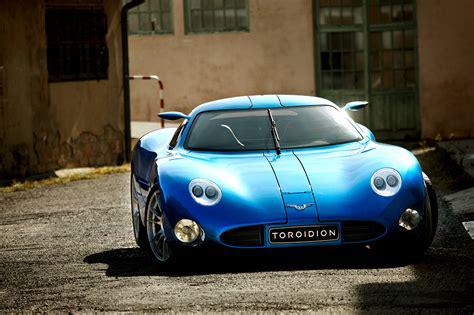

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


In [95]:
#!L
pil_image = from_s3('smarthive',image_paths[980])
print(pil_image.size)
pil_image

##  **Вычисление признаков**

В этой части используем модель ResNet50 с весами, предварительно обученными на ImageNet, чтобы сформировать признаки для  изображений.  
Загружаем модель и сохраняем ее в  объектной модели Keras.   
Размер входного изображения по умолчанию для этой модели равен (224, 244) с 3 цветными каналами и требует, чтобы параметр input\_shape=(224, 224, 3).

In [96]:
#!l
model = ResNet50(weights='imagenet',  input_shape=(224, 224, 3))

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


In [97]:
#!L
def file_batch(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


 The featurize\_images function processes the image files in small chunks (default is set to batch\_size=32) by first loading the images in the batch into a target size of (224,224), then converting them into four dimensional tensors which keras model expects as input. After, that model's batch prediction method is called to calculate the features of each image.

In [100]:
#!L
def featurize_images(file_list, model, batch_size=32):
    features = []
    
    for fb in tqdm(file_batch(file_list, batch_size)):
        load_img = []
        for file_path in fb:
            #print(file_path)
            img = from_s3('smarthive',file_path).resize((224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            load_img.append(preprocess_input(x))
            arr_pred = model.predict_on_batch(np.concatenate(load_img))
            #print('arr_pred.shape {0} arr_pred.squeeze.shape: {1}'.format(arr_pred.shape,np.squeeze(arr_pred).shape))
        features.extend(arr_pred.squeeze())
    return np.array(features)


/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


 Next, you will call the function to compute the features and save them into the share folder. The execution of the following cell may take up to 10-15 minutes so feel free to read through the links provided in the beginning of the notebook in order to learn more about CNNs, ResNet50, Keras, CNTK and LightGBM.

In [101]:
#!L
%%time

features_filename = 'ImageClassificationML/features_resnet50.npy'
if path.isfile(features_filename):
    print("Features found!")
    features = np.load(features_filename)
else:
    print("Computing features")
    features = featurize_images(image_paths, model) 
    np.save(features_filename, features)


0it [00:00, ?it/s]

Computing features


47it [02:50,  3.62s/it]


CPU times: user 1min 1s, sys: 11 s, total: 1min 12s
Wall time: 2min 51s


/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


Check the shape of the computed features.

In [102]:
#!L
features.shape

(1485, 1000)

## **Training and Cross Validation**

In this section, you will use the features calcuated in the previous section to train a LightGBM classifier. You will be performing cross validation to understand the performance of the model. You will use [scikit-learn's stratified K-fold cross validation](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html "http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html") where the folds are made by preserving the percentage of samples from each class. This is an important step especially if you are using your own data and number of images in one of the categories is substentially less than the other category. You will be using 5 fold cross validation. You can pick other values by changing n\_splits in the next cell to the desired number of folds.

In [103]:
#!L
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=2048, shuffle=True)
cv_results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'Confusion Matrix'])


You will use a helper function called classification\_metircs to calculate the evaluation metrics for each fold.

In [104]:
#!L

def classification_metrics(y_true, y_pred_proba, threshold=0.5):
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred)
    cm_dict['Recall'] =  recall_score(y_true, y_pred)
    cm_dict['F1'] =  f1_score(y_true, y_pred) 
    cm_dict['AUC'] = roc_auc_score(y_true, y_pred_proba)
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


Next, provide parameters of the LightGBM model. You can experiment with different parameters.

In [105]:
#!L
params = {'num_leaves': 256,
           'learning_rate': 0.1,
           'min_split_gain': 0.1,
           'min_child_weight': 30,
           'reg_lambda': 1,
           'subsample': 1,
           'objective':'binary',
           'task': 'train',
           'verbose': -1
           }

Below, you will train your classifer for each fold and print the metrics.

In [106]:
#!L
for train_index, test_index in tqdm(skf.split(features, labels)):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    clf = lgb.train(params, lgb_train, num_boost_round=500, verbose_eval=False)
    y_pred_proba = clf.predict(X_test, verbose_eval=False)
    cm_dict = classification_metrics(y_test, y_pred_proba)
    print(cm_dict)
    cv_results = cv_results.append(classification_metrics(y_test, y_pred_proba),ignore_index=True)

1it [00:00,  1.10it/s]

{'Accuracy': 0.9797979797979798, 'Precision': 0.9863013698630136, 'Recall': 0.972972972972973, 'F1': 0.979591836734694, 'AUC': 0.998050063486305, 'Confusion Matrix': [[147, 2], [4, 144]]}


2it [00:01,  1.20it/s]

{'Accuracy': 0.9730639730639731, 'Precision': 0.9861111111111112, 'Recall': 0.9594594594594594, 'F1': 0.9726027397260274, 'AUC': 0.9974605477961184, 'Confusion Matrix': [[147, 2], [6, 142]]}


3it [00:02,  1.29it/s]

{'Accuracy': 0.9595959595959596, 'Precision': 0.9473684210526315, 'Recall': 0.972972972972973, 'F1': 0.9599999999999999, 'AUC': 0.9961001269726102, 'Confusion Matrix': [[141, 8], [4, 144]]}


4it [00:02,  1.37it/s]

{'Accuracy': 0.9865319865319865, 'Precision': 0.9865771812080537, 'Recall': 0.9865771812080537, 'F1': 0.9865771812080537, 'AUC': 0.9966442953020134, 'Confusion Matrix': [[146, 2], [2, 147]]}


5it [00:03,  1.43it/s]

{'Accuracy': 0.9562289562289562, 'Precision': 0.9533333333333334, 'Recall': 0.959731543624161, 'F1': 0.9565217391304347, 'AUC': 0.9953292218392888, 'Confusion Matrix': [[141, 7], [6, 143]]}



/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, lgb_train, s3
  warnings.warn(message)


Now, you will train our model on the whole dataset one last time to obtain the final trained model for operationalization. You will also plot the confusion matrix for this model.

In [107]:
#!L

lgb_train = lgb.Dataset(features, labels, free_raw_data=False)
clf = lgb.train(params, lgb_train, num_boost_round=500)
y_pred_proba = clf.predict(features)

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: lgb_train
  warnings.warn(message)


You will use the following helper function to plot the confusion matrix.

In [111]:
#!L
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


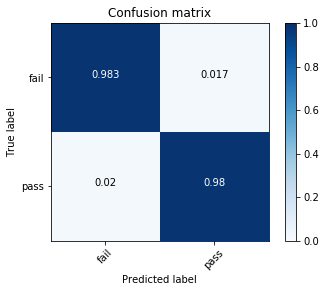

Confusion Matrix:
[[730  13]
 [ 15 727]]


/usr/local/lib/python3.7/dist-packages/ml_kernel/kernel.py:434: UserWarning: The following variables cannot be serialized: featurize_images, from_s3, s3
  warnings.warn(message)


In [112]:
#!L
cm = np.asarray(classification_metrics(labels, y_pred_proba)['Confusion Matrix'])
plot_confusion_matrix(cm, ['fail','pass'], normalize=True)
print('Confusion Matrix:')
print(cm)

## Save the model

Save the model file to the shared folder. You will load this file in the next notebook for operation vizualization.

In [113]:
#!L
model_path = 'ImageClassificationML/lightgbm_classifier.model'
clf.save_model(model_path)

In [ ]:
#!L
